In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [83]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
  # print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [13]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

### Creating embedding

In [14]:
# Turning 27-d word space to 2-d emb space
C = torch.randn((27, 2))

In [15]:
C[5]
# Or we can use this instead
# F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-1.0415,  0.2779])

In [31]:
# C[torch.tensor([5, 6, 7])]
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

### Hidden Layer

In [32]:
# (input=3*2 from emb, output_siz/num of neurons)
W1 = torch.randn((6, 100)) 
# number of biases is equal to num of neurons/output size
b1 = torch.randn(100)

```
# We need to concatenate embs for 3 words via view
emb_reshaped = emb[:].view(-1, 6)
emb_reshaped[0]

# or via cat
emb_cat = torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1)
emb_cat[0]

# or via unbind + cat 
# Unbind slices the tensor along the given dim
torch.cat(torch.unbind(emb, dim=1), dim=1).shape

# Or like this
emb.view(32,6)
```

In [63]:
# Output from hidden layer
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) 
h.shape
# check the broadcasting
# [32, 100] + [100]
# ----------
# [32, 100]
#     [100]

torch.Size([32, 100])

### Final layer

In [64]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [65]:
logits = h @ W2 + b2

In [66]:
logits.shape

torch.Size([32, 27])

In [67]:
counts = logits.exp()

In [68]:
prob = counts / counts.sum(1, keepdims=True)

In [69]:
prob.shape

torch.Size([32, 27])

### Checking the labels' probs
#### To check the performance of the model

In [71]:
# negative log-likehood loss (nlll)
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(18.5062)

### Now made respectable :)

In [134]:
X. shape, Y.shape # Dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [118]:
g = torch.Generator().manual_seed(2147483647) # For reproducibility 
C = torch.randn((27, 2), generator = g)
W1 = torch.randn((6, 100), generator = g)
b1 = torch.randn(100, generator = g)
W2 = torch.randn((100, 27), generator = g)
b2 = torch.randn(27, generator = g)
parameters = [C, W1, W2, b1, b2]

In [119]:
# Num of parameters
sum(p.nelement() for p in parameters)

3481

In [120]:
for p in parameters:
  p.requires_grad = True

In [121]:
# HPO
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [129]:
lri = []
lossi = []
for i in range(10000):
  
  # minibatch construct
  ix = torch.randint(0, X.shape[0], (32, ))

  # Forward pass
  emb = C[X[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
  logits = h @ W2 + b2
  # counts = logits.exp()
  # prob = counts / counts.sum(dim=1, keepdims=True)
  # loss = -prob[torch.arange(32), Y].log().mean() # nlll
  # Or instead we can just use cross_entropy
  loss = F.cross_entropy(logits, Y[ix])

  # Backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # Updating the weights 
  # lr = lrs[i] # HPO part
  lr = 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # Track stats
  # lri.append(lre[i])
  # lossi.append(loss.item())

print(loss.item())

2.3408913612365723


In [130]:
# plt.plot(lri, lossi)

In [131]:
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
print(loss.item())

2.342784881591797


## Splitting the dataset

In [133]:
# Training split , dev/validation split, test split
# 80/10/10
# build the dataset
def build_dataset(words):
  block_size = 3 # context length: how many characters do we take to predict the next one?
  X, Y = [], []
  for w in words:
    
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append
    
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

#### Training

In [157]:
Xtr.shape, Ytr.shape # Dataset

(torch.Size([182580, 3]), torch.Size([182580]))

In [158]:
g = torch.Generator().manual_seed(2147483647) # For reproducibility 
C = torch.randn((27, 2), generator = g)
W1 = torch.randn((6, 300), generator = g)
b1 = torch.randn(300, generator = g)
W2 = torch.randn((300, 27), generator = g)
b2 = torch.randn(27, generator = g)
parameters = [C, W1, W2, b1, b2]

In [159]:
# Num of parameters
sum(p.nelement() for p in parameters)

10281

In [160]:
for p in parameters:
  p.requires_grad = True

In [161]:
stepi = []
lossi = []
for i in range(30000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32, ))

  # Forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])

  # Backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # Updating the weights 
  lr = 0.1
  for p in parameters:
    p.data += -lr * p.grad

  # Track stats
  stepi.append(i)
  lossi.append(loss.item())

print(loss.item())

2.2452282905578613


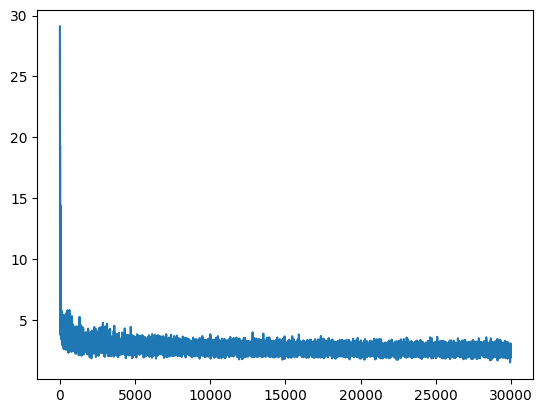

In [162]:
plt.plot(stepi, lossi)

#### Evaluating using dev split

In [163]:
emb = C[Xval]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yval)
loss

tensor(2.5678, grad_fn=<NllLossBackward0>)

In [ ]:
# To memorize
emb = C[Xval]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yval)
loss

tensor(2.5678, grad_fn=<NllLossBackward0>)

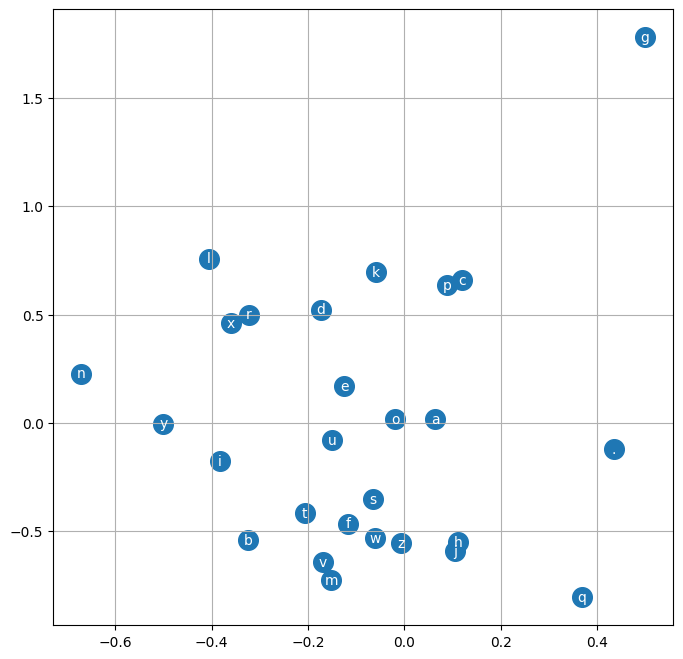

In [164]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

## Let's increase the size of embedding

In [165]:
Xtr.shape, Ytr.shape # Dataset

(torch.Size([182580, 3]), torch.Size([182580]))

In [169]:
g = torch.Generator().manual_seed(2147483647) # For reproducibility 
C = torch.randn((27, 10), generator = g)
W1 = torch.randn((30, 200), generator = g)
b1 = torch.randn(200, generator = g)
W2 = torch.randn((200, 27), generator = g)
b2 = torch.randn(27, generator = g)
parameters = [C, W1, W2, b1, b2]

In [170]:
# Num of parameters
sum(p.nelement() for p in parameters)

11897

In [171]:
for p in parameters:
  p.requires_grad = True

In [172]:
stepi = []
lossi = []

In [177]:
for i in range(50000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32, ))

  # Forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])

  # Backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # Updating the weights 
  lr = 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # Track stats
  stepi.append(i)
  lossi.append(loss.log10().item())

print(loss.item())

2.652480363845825


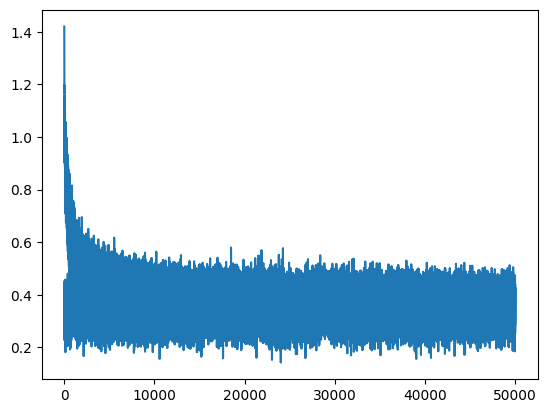

In [178]:
plt.plot(stepi, lossi)

### Evaluating using dev split

In [179]:
emb = C[Xval]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yval)
loss

tensor(2.1936, grad_fn=<NllLossBackward0>)

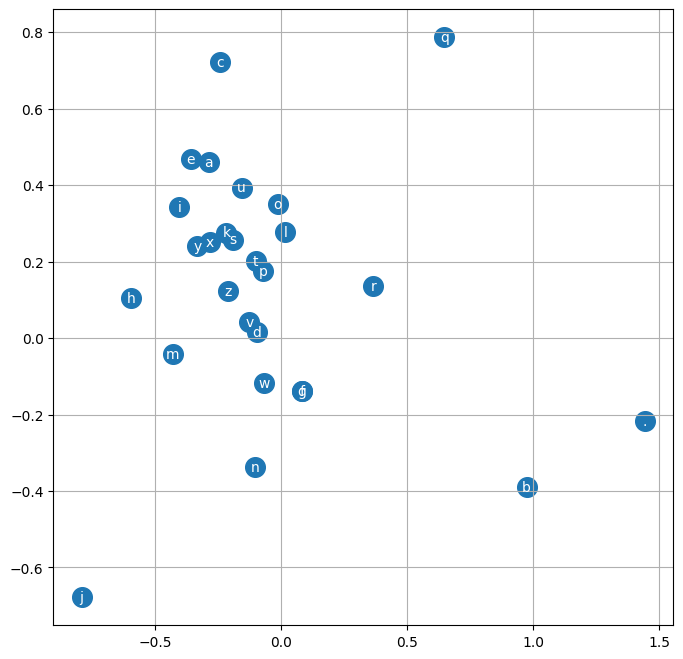

In [180]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

## Sampling from the model

In [191]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
  out = []
  context = [0] * block_size
  while True:
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    prob = F.softmax(logits, dim=1)
    # print(prob)
    ix = torch.multinomial(prob, num_samples=1, generator = g)
    out.append(itos[ix.item()])
    context = context[1:] + [ix]
    if ix == 0:
      break
  print(''.join(out))

moha.
mayah.
see.
mad.
rylle.
emmrs.
ejd.
leg.
adered.
eliah.
miloe.
lekeiseananar.
kayzion.
karin.
shdavrishiriel.
kinde.
jeyshanthustiu.
zayven.
jamell.
ehs.


In [183]:
itos[13]

'm'